## Astronomy 406 "Computational Astrophysics" (Fall 2016)

### Week 6: Fitting model to data: Linear Regression

<b>Reading:</b> notes below, as well as $\S$[15.1-15.4](https://umich.instructure.com/files/2682006/download?download_frd=1) of [Numerical Recipes](http://numerical.recipes), and $\S$4.2-4.3 and 8.2 of [Machine Learning](http://www.astroml.org/)</a>.

In [1]:
%matplotlib inline
from matplotlib import rcParams
rcParams["savefig.dpi"] = 90
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize, stats
np.random.seed(0)

#### Fitting model to data

One of the most common tasks of analyzing data is fitting a simple model that describes the distribution of data points in some optimal way. The model often has several parameters, whose best values are to be determined by the fitting procedure. This week we consider a very common example - fitting a line to data, also known as <i>linear regression</i>.

$y = f(x | a,b) = a + b x$  (notation in Numerical Recipes),

$f(x | \vec{\theta}) = \theta_0 + \theta_1 x$  (notation in Machine Learning).

In addition to data points $x_i$ and $y_i$, we will also have their estimated measurement errors $\sigma_{x,i}$ and $\sigma_{y,i}$.

If the errors of independent variable $\sigma_{x,i}$ can be ignored, the best-fit values of parameters $a$ and $b$ can be found by minimizing the $\chi^2$ function

$$ \chi^2(a,b) = \sum_i \left({y_i - f(x_i|a,b) \over \sigma_{y,i}}\right)^2. $$

The explicit solution is given by equations 15.2.4 and 15.2.6 in NR, as well as equations 8.9-8.13 in ML.

Let's take a new data set. File <b>gc_galaxy.dat</b> (located in Canvas/Files/Data files) contains measurements of the luminosity of some nearby galaxies, $\log_{10}{L}$ and its error estimate ($L$ in units of solar luminosity) and the combined mass of all globular clusters in each galaxy, $\log_{10}{M}_{GC}$ and its error estimate ($M$ in units of solar mass).  Before doing any statistical analysis, it is always a good idea to look at the data first.

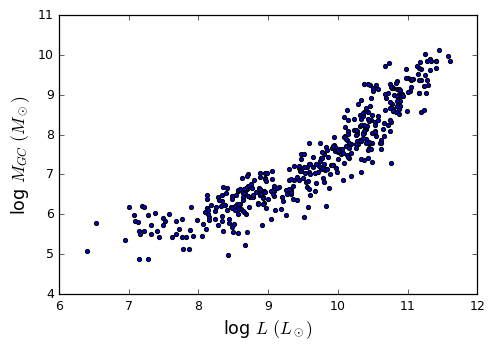

In [2]:
Lgal, dLgal, Mgc, dMgc = np.loadtxt('gc_galaxy.dat', unpack=True)

plt.scatter(Lgal, Mgc, s=10)
plt.xlabel(r'log $L \ (L_\odot)$', size=14)
plt.ylabel(r'log $M_{GC} \ (M_\odot)$', size=14)
plt.show()

The distribution of points appears non-linear, but if we choose only those with $\log_{10}{L} > 9$, it would be better described by a linear relation:

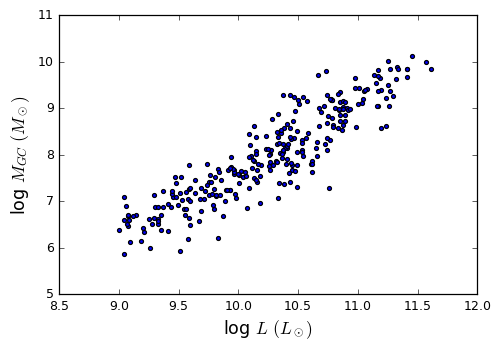

In [3]:
ind = (Lgal > 9) 
x = Lgal[ind]; dx = dLgal[ind]; y = Mgc[ind]; dy = dMgc[ind];

plt.scatter(x, y, s=10)
plt.xlabel(r'log $L \ (L_\odot)$', size=14)
plt.ylabel(r'log $M_{GC} \ (M_\odot)$', size=14)
plt.show()

Correlation coefficients can confirm to us that the two variables are related:

In [4]:
r, p = stats.pearsonr(x, y)
rs, ps = stats.spearmanr(x, y)
print 'Pearson  r = %.3f  probability of no correlation = %.1e' % (r, p)
print 'Spearman r = %.3f  probability of no correlation = %.1e' % (rs, ps)

Pearson  r = 0.906  probability of no correlation = 8.6e-106
Spearman r = 0.910  probability of no correlation = 1.7e-108


We can also plot errorbars, to see the actual extent of the distribution.

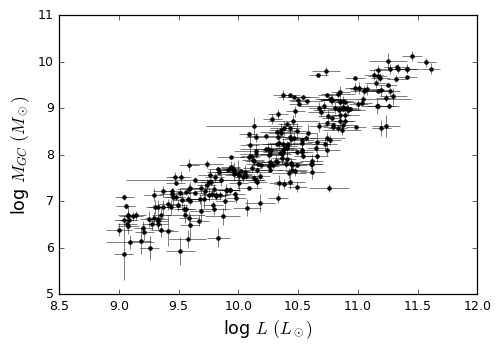

In [4]:
plt.errorbar(x, y, xerr=dx, yerr=dy, fmt='.k', elinewidth=0.4, capsize=0)
plt.xlabel(r'log $L \ (L_\odot)$', size=14)
plt.ylabel(r'log $M_{GC} \ (M_\odot)$', size=14)
plt.show()

Let's code and plot the explicit solution from NR, without taking into account errors of x.
(Essentially, we minimize the chi-squared function.)

a = -7.0500 ± 0.0791  b = 1.4973 ± 0.0076
covariance of a and b = -0.00060


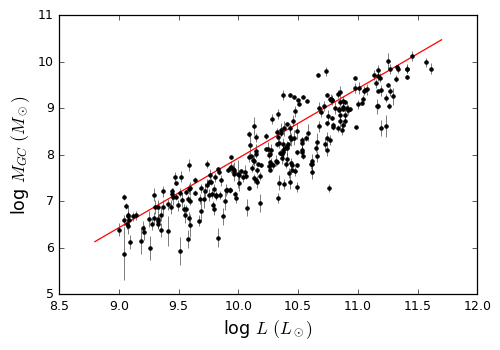

In [5]:
s = np.sum(1./dy**2)
sx = np.sum(x/dy**2)
sy = np.sum(y/dy**2)
sxx = np.sum(x**2/dy**2)
sxy = np.sum(x*y/dy**2)
d = s*sxx - sx**2
a = (sxx*sy - sx*sxy)/d
b = (s*sxy - sx*sy)/d
da = np.sqrt(sxx/d)
db = np.sqrt(s/d)

print 'a = %.4f ± %.4f  b = %.4f ± %.4f' % (a,da,b,db)
print 'covariance of a and b = %.5f' % (-sx/d)

xa = np.linspace(8.8, 11.7)
plt.plot(xa, a+b*xa, 'r-')
plt.errorbar(x, y, yerr=dy, fmt='.k', elinewidth=0.4, capsize=0)
plt.xlabel(r'log $L \ (L_\odot)$', size=14)
plt.ylabel(r'log $M_{GC} \ (M_\odot)$', size=14)
plt.show()

<b>Question:</b> Does the fit look as you would have naively drawn it by hand?

No: values with less error "weigh" less in the chi2 function, and so affect the best fit line the least.

Let's now check this calculation with SciPy's routine that explicitly minimizes function $\chi^2(a,b)$:

In [6]:
def chi2(p):
    return np.sum(np.square((y-p[0]-p[1]*x)/dy))

o = optimize.minimize(chi2, [0.,1.])

print 'a = %.4f ± %.4f  b = %.4f ± %.4f' % \
  (o.x[0], np.sqrt(o.hess_inv[0,0]), o.x[1], np.sqrt(o.hess_inv[1,1]))
print 'covariance of a and b = %.5f' % (o.hess_inv[0,1])
print 'chi^2 per dof = %.2f' % (chi2(o.x)/(len(x)-2))

a = -7.0500 ± 0.0298  b = 1.4973 ± 0.0032
covariance of a and b = -0.00009
chi^2 per dof = 70.47


The best-fit parameters are indeed the same.  It is the correct fit for our chosen model!

The value of $\chi^2$ per degree of freedom is a useful measure of goodness of the fit: <i>best</i> does not necessarily mean <i>good</i>!  We use up two degrees of freedom to calculate $a$ and $b$, therefore $N_{\mathrm{dof}} = N-2$.

The fit is good when $\chi^2/N_{\mathrm{dof}} \approx 1$.  Our value is $\chi^2/N_{\mathrm{dof}} > 70$, so the fit is not so good.  Which we already know just by looking at the plot.

Now we can include errors of $x$ by minimizing the modified <i>merit</i> function (equation 15.3.2 in NR):

$$ \chi^2(a,b) = \sum_i {(y_i - f(x_i|a,b))^2 \over \sigma_{y,i}^2 + b^2 \sigma_{x,i}^2}. $$

The new expression in the denominator is the variance of the linear combination $y_i - a - b x_i$.

a = -8.6488 ± 0.0806  b = 1.6261 ± 0.0079
covariance of a and b = -0.00063
chi^2 per dof = 5.45


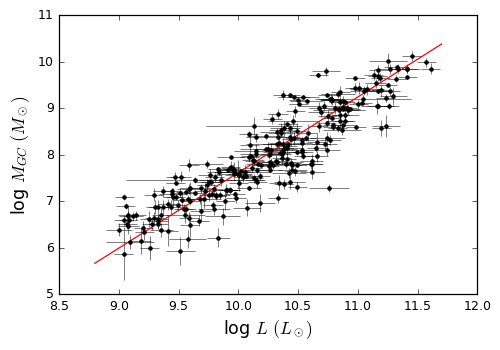

In [7]:
def chi2_2(p):
    return np.sum((y-p[0]-p[1]*x)**2/(dy**2 + (p[1]*dx)**2))

o = optimize.minimize(chi2_2, [0.,1.])

print 'a = %.4f ± %.4f  b = %.4f ± %.4f' % (o.x[0],np.sqrt(o.hess_inv[0,0]),o.x[1],np.sqrt(o.hess_inv[1,1]))
print 'covariance of a and b = %.5f' % (o.hess_inv[0,1])
print 'chi^2 per dof = %.2f' % (chi2_2(o.x)/(len(x)-2))

plt.plot(xa, o.x[0]+o.x[1]*xa, 'r-')
plt.errorbar(x, y, xerr=dx, yerr=dy, fmt='.k', elinewidth=0.4, capsize=0)
plt.xlabel(r'log $L \ (L_\odot)$', size=14)
plt.ylabel(r'log $M_{GC} \ (M_\odot)$', size=14)
plt.show()

What a difference the errors make!  Now $\chi^2/N_{\mathrm{dof}} \approx 5$, which is much better than before.  However, it is still not close to unity.  We have taken all available information into account, and yet our linear model does not describe the data perfectly.  Many data points lie farther away from the best-fit line than their measured errors.  This indicates that the data are drawn a distribution with an <i>instrinsic scatter</i>, beyond the measurement errors.

Although there is no explicit solution for best-fit parameters in the case of errors in both directions, we do not have to run the minimization routine for both parameters.  Equation 15.3.4 in NR shows that $a$ can be derived analytically via $b$:

$$ a = {\sum_i w_i (y_i - b x_i) \over \sum_i w_i}, $$

where the weights $w_i \equiv (\sigma_{y,i}^2 + b^2 \sigma_{x,i}^2)^{-1}$.

<b>Exercise 1:</b> Re-write the <b>chi2_2</b> function to take only one argument $b$, returning both $\chi^2$ and $a$, and run the minimization routine on it. Check if you obtain the same values of $a$, $b$, and $\chi^2$.

In [8]:
def chi2_2(b):
    def w(b):
        return (dy**2 + (b * dx)**2)**(-1)
    a = np.sum(w(b) * (y - b * x)) / np.sum(w(b))
    return (np.sum((y - a - b*x)**2/(dy**2 + (b*dx)**2)), a)

def chi2_2_scalar(b):
    return chi2_2(b)[0]

o = optimize.minimize(chi2_2_scalar, 1.)
best_b = o.x[0]
best_chi, best_a = chi2_2(best_b)

print 'Best b:', best_b, ' ±', np.sqrt(o.hess_inv[0, 0])
print 'Best a:', best_a
print 'Best (chi**2 / N):', best_chi / (len(x) - 2)


Best b: 1.62610401934  ± 0.0128818193061
Best a: -8.64881502362
Best (chi**2 / N): 5.45175036767


### Maximum Likelihood Estimation

Now let's do a more rigorous formulation of the linear regression problem.  We can include instrinsic scatter by re-defining our model function:

$y = f(x | a,b,\sigma) = a + b x + \epsilon$,

where the scatter of each data point $\epsilon_i$ is described by a normal distribution $N(0,\sigma)$.  Now $f$ is a function of three parameters to be estimated.

The probability of drawing perfect model values $\hat{x}_i$ and $\hat{y}_i$ (without any measurement errors) from this distribution is

$$ P(\hat{y}_i | \hat{x}_i) = {1 \over \sqrt{2\pi} \sigma} \exp\left[-{(\hat{y}_i - f(\hat{x}_i))^2 \over 2 \sigma^2}\right]. $$

Assume that the actual measured points $x_i$ and $y_i$ also obey the normal distribution with their errors:

$$
P(x_i | \hat{x}_i) = {1 \over \sqrt{2\pi} \sigma_{x,i}} \exp\left[-{(x_i - \hat{x}_i)^2 \over 2 \sigma_{x,i}^2}\right], 
\qquad
P(y_i | \hat{y}_i) = {1 \over \sqrt{2\pi} \sigma_{y,i}} \exp\left[-{(y_i - \hat{y}_i)^2 \over 2 \sigma_{y,i}^2}\right].
$$

Then the probability of measuring $y_i$ for a given $x_i$ is

$$ P(y_i | x_i) \propto P(y_i | \hat{y}_i) P(\hat{y}_i | \hat{x}_i) P(\hat{x}_i | x_i), $$

and $P(\hat{x}_i | x_i) = P(x_i | \hat{x}_i)$ by symmetry.  Combining the probabilities with appropriate normalization gives

$$ P(y_i | x_i) = {1 \over \sqrt{2\pi} \sigma_i} \exp\left[-{(y_i - a - b x_i)^2 \over 2 \sigma_i^2}\right], $$

with $\sigma_i^2 \equiv \sigma_{y,i}^2 + b^2 \sigma_{x,i}^2 + \sigma^2$.

The <i>likelihood</i> of the whole data set is

$$ {\cal L} = \prod_i P(y_i | x_i) = \prod_i {1 \over \sqrt{2\pi} \sigma_i} \exp\left[-{(y_i - a - b x_i)^2 \over 2 \sigma_i^2}\right]. $$

Best-fit parameters correspond to maximum value of ${\cal L}$. The likelihood is <i>not</i> normalized like the probability and can take very small values (product of many numbers less than unity). It is more convenient to work with log-likelihood:

$$ 2\ln{\cal L} = -\sum_i \ln{\sigma_i^2} - \sum_i {(y_i - a - b x_i)^2 \over \sigma_i^2}. $$

It is similar to the $\chi^2$ function and leads to the same best-fit parameters in the limiting case $\sigma_i = \sigma_{y,i}$.  In general, however, $\sigma_i = \sigma_i(b,\sigma)$ and the likelihood must be maximized as a function of these two parameters.  The intercept value $a$ can still be calculated analytically with the same expresion as above but with modified weights $w_i \equiv \sigma_{i}^{-2}$.

(Note: $P(a|b)P(b|c) = P(a|c)$)

<b>Exercise 2:</b> Write the $2\ln{\cal L}$ function to take two arguments $b$ and $\sigma$, and find its maximum. Check if you obtain the same values of $a$ and $b$ as above, and plot the best-fit model with the data. What is the new $\chi^2$?

In [37]:
def minuslnLikelihood(p):
    b, s = p
    sig2_i = dy**2 + (b * dx)**2 + s**2
    w_i = np.sqrt(sig2_i)
    a = np.sum(w_i * (y - b * x)) / np.sum(w_i)
    lnSum = np.sum(np.log(sig2_i))
    chiSum = np.sum((y - a - b*x)**2 / sig2_i)
    return (lnSum + chiSum)

def chi2_3(p):
    a, b, s = p
    return np.sum((y - a - b * x)**2 / s)

o = optimize.minimize(minuslnLikelihood, [1.,0.])

b = o.x[0]
sigma = o.x[1]
sig2i = dy**2 + (b * dx)**2 + sigma**2
w = 1/sig2i
a = np.sum(w * (y - b * x)) / np.sum(w)
print 'best b:', o.x[0]
print 'Previous best b:', best_b
print 'best a:', a
print 'Previous best a:', best_a
print 'best sigma:', o.x[1]
print 'best chi-squared:', chi2_3([a, b, sigma]) / (len(x) - 3)

best b: 1.43591751938
Previous best b: 1.62610401934
best a: -6.71698760857
Previous best a: -8.64881502362
best sigma: 0.367414411614
best chi-squared: 0.480344874245


#### Understanding the error distribution of best-fit parameters

Let's plot the range of models allowed by the best-fit parameters and their errors.

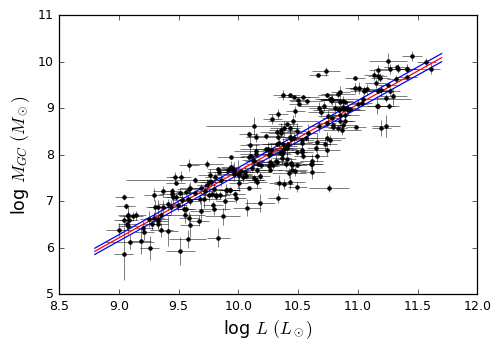

In [38]:
plt.plot(xa, a+b*xa, 'r-')
plt.plot(xa, a+(b+db)*xa, 'b-')
plt.plot(xa, a+(b-db)*xa, 'b-')

plt.errorbar(x, y, xerr=dx, yerr=dy, fmt='.k', elinewidth=0.4, capsize=0)
plt.xlabel(r'log $L \ (L_\odot)$', size=14)
plt.ylabel(r'log $M_{GC} \ (M_\odot)$', size=14)
plt.show()

#### Bootstrap

What do estimated errors of the best-fit parameters mean?  Do they obey a Gaussian statistic with mean $a$ and standard deviation $da$?  Or do they obey a different distribution, and how can we know that?  These questions are the reason to try to understand the whole distribution of the model parameters.

One of the simplest, and yet accurate and effective, ways of estimating the parameter distribution is <b>bootstrap</b>.  In this method we create many new datasets based on the original dataset, and derive the best-fit parameters for all of them, thus creating a distribution of the parameter values.  The trick is to have the new datasets to obey the same distribution function as the original sample.  This is achieved by drawing data points from the original dataset $x_i, y_i$, with repetition.

The simplest way to draw a bootstrap sample is to generate a new array of indices $j$, composed of random integers from 0 to $N-1$. Then the new data set is simply $x_j, y_j$.  The phrase "with repetition" means that some data points may appear in the new dataset multiple times, while some others will disappear.

<b>Exercise 3:</b> Re-write the $2\ln{\cal L}$ function to take additional arguments for the bootstrapped sample ($x,y,dx,dy$).  Write additional function that evaluates the intercept given the parameter array $p$ and the bootstrapped sample.

In [ ]:
def lnLikelihood(p,xb,yb,dxb,dyb):
    return answer

def intercept(p,xb,yb,dxb,dyb):
    return answer

In [ ]:
nd = len(x)
aa, bb, ss = [], [], []
amean, bmean, smean = 0., 0., 0.
asig, bsig, ssig = 0., 0., 0.
iboot = 0
icheck = 100
inext = icheck
cont = True

while cont and iboot < 10000:
    
    iboot += 1
    ir = np.random.randint(0, nd, nd)
    xb = x[ir]; yb = y[ir]; dxb = dx[ir]; dyb = dy[ir];
    
    o = optimize.minimize(lnLikelihood, [1.,0.1], args=(xb,yb,dxb,dyb))
    
    aa.append(intercept(o.x,xb,yb,dxb,dyb))
    bb.append(o.x[0])
    ss.append(abs(o.x[1]))
    
    if iboot >= inext:
        amean_last, bmean_last, smean_last = amean, bmean, smean
        asig_last, bsig_last, ssig_last = asig, bsig, ssig
        amean, bmean, smean = np.mean(aa), np.mean(bb), np.mean(ss)
        asig, bsig, ssig = np.std(aa), np.std(bb), np.std(ss)
        
        d = abs(amean-amean_last) + abs(bmean-bmean_last) + abs(smean-smean_last)\
            + abs(asig-asig_last) + abs(bsig-bsig_last) + abs(ssig-ssig_last)
            
        if d < 0.006:
            cont = False
            
        print "iboot =", iboot, "d = {0:.4f}".format(d)
        print "a = {0:.3f} +- {1:.3f} b = {2:.3f} +- {3:.3f} s = {4:.3f} +- {5:.3f}"\
              .format(amean, asig, bmean, bsig, smean, ssig)
        inext += icheck    
        
plt.xlabel('a')
plt.ylabel('N')
plt.hist(aa)
plt.show()

plt.xlabel('b')
plt.ylabel('N')
plt.hist(bb)
plt.show()

plt.xlabel('$\sigma$')
plt.ylabel('N')
plt.hist(ss)
plt.show()

Let's now plot the range of models allowed by the best-fit parameters and their errors.

In [ ]:
plt.plot(xa, a+b*xa, 'r-')
plt.plot(xa, a+(b+bsig)*xa, 'r-')
plt.plot(xa, a+(b-bsig)*xa, 'r-')
plt.plot(xa, a+asig+b*xa, 'b-')
plt.plot(xa, a-asig+b*xa, 'b-')

plt.errorbar(x, y, xerr=dx, yerr=dy, fmt='.k', elinewidth=0.4, capsize=0)
plt.xlabel(r'log $L \ (L_\odot)$', size=14)
plt.ylabel(r'log $M_{GC} \ (M_\odot)$', size=14)
plt.show()

#### Confidence limits

Bootstrap gives us the distributions of each of the model parameters.  We can use them to set confidence limits on the derived best-fit parameters.

<b>Exercise 4:</b> Write a routine to calculate the range containing a given percentage of the bootstrap distribution, for each of the model parameters.  For example, return $da$ such that 90% (should be free parameter) of the values of $a$ are within $a \pm da$.

Having bootstrap distributions also allows us to investigate the relations between the best-fit parameters.  For example, there is a strong anti-correlation of $a$ and $b$:

In [ ]:
plt.xlabel('a')
plt.ylabel('b')
plt.scatter(aa, bb, s=10)
plt.show()

This anti-correlation arises because the pivot point of our linear model (at $x=0$) is far from the actual range of data ($x>0$).  We can reduce it by choosing a different pivot point, somewhere in the middle of the distribution.  For example, the mean value of $x$.  This means we are re-defining our model as

$y = f(x | a,b,\sigma) = a + b (x-x_0) + \epsilon$.

The new intercept relates to the old one as $a_{new} = a_{old} + b x_0$. We should remember it when comparing results with the previous fit.

<b>Exercise 5:</b> Re-write the above functions <b>lnLikelihood</b> and <b>intercept</b> to include $x_0$.  Compare the 90% confidence limits of all model parameters with the case of $x_0=0$.  Check the correlation of $a$ and $b$.


